# **Creating Train Val, Test**

In [10]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import random

# Download necessary NLTK data
import nltk
nltk.download('punkt')

def clean_text_for_nlp(text):
    # Remove metadata and headers (modify if the structure is different)
    text = re.sub(r'the project gutenberg ebook.*?contents', '', text, flags=re.DOTALL | re.IGNORECASE)
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace newlines with spaces
    text = re.sub(r'\n', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-z0-9.,!?;\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def process_sentences(sentences):
    processed = []
    for sentence in sentences:
        # Add space before punctuation for easier tokenization later
        sentence = re.sub(r'([.,!?;])', r' \1', sentence)
        
        # Tokenize words
        words = word_tokenize(sentence)
        
        # Keep sentences with more than 5 words (remove very short sentences)
        if len(words) > 5:
            processed.append(sentence)
    
    return processed

# Read the file
with open('/kaggle/input/data-set/Auguste_Maquet.txt', 'r', encoding='utf-8') as file:
    text = file.read()

print(f"Original text length: {len(text)} characters")

# Clean the text
cleaned_text = clean_text_for_nlp(text)

print(f"Cleaned text length: {len(cleaned_text)} characters")

# Tokenize sentences
sentences = sent_tokenize(cleaned_text)

print(f"Number of sentences after initial tokenization: {len(sentences)}")

# Process sentences
cleaned_sentences = process_sentences(sentences)

print(f"Total number of sentences after cleaning: {len(cleaned_sentences)}")

# Print first few sentences for inspection
print("\nFirst 5 cleaned sentences:")
for i, sentence in enumerate(cleaned_sentences[:5]):
    print(f"{i+1}. {sentence}")

# Shuffle the sentences
random.shuffle(cleaned_sentences)

# Calculate split sizes
train_size = int(0.7 * len(cleaned_sentences))
val_size = int(0.1 * len(cleaned_sentences))
test_size = len(cleaned_sentences) - train_size - val_size

# Split the data
train_sentences = cleaned_sentences[:train_size]
val_sentences = cleaned_sentences[train_size:train_size+val_size]
test_sentences = cleaned_sentences[train_size+val_size:]

# Write to files
def write_to_file(filename, data):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write('\n'.join(data))

write_to_file('train.txt', train_sentences)
write_to_file('val.txt', val_sentences)
write_to_file('test.txt', test_sentences)

print(f"\nData split complete:")
print(f"Train set: {len(train_sentences)} sentences")
print(f"Validation set: {len(val_sentences)} sentences")
print(f"Test set: {len(test_sentences)} sentences")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Original text length: 5351663 characters
Cleaned text length: 5179849 characters
Number of sentences after initial tokenization: 59093
Total number of sentences after cleaning: 48341

First 5 cleaned sentences:
1. overlap those of two other volumes it includes all the chapters of ebook 2609 and the first 28 chapters of 2681 title pg ebook dates volume chapters ten years later 1258 16601661 3 1104 contents chapter i . the shade of cardinal richelieu .
2. anne of austria at the age of fortysix .
3. chapter v . the gascon and the italian .
4. dartagnan in his fortieth year .
5. touches upon the strange effects a halfpistole may have .

Data split complete:
Train set: 33838 sentences
Validation set: 4834 sentences
Test set: 9669 sentences


# with remving punctuation NN LM using glove 5 epochs 

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import re
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Function to remove punctuation from sentences
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    # Create an embedding matrix
    embedding_dim = glove_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocab, word_to_idx, idx_to_word, embedding_matrix

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super(NeuralLanguageModel, self).__init__()
        
        # Use pre-trained GloVe embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embeddings.weight.requires_grad = False  # Keep the embeddings fixed (non-trainable)

        self.fc1 = nn.Linear(embedding_dim * 5, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, vocab_size)  # Output layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embeddings(x)  # Shape: (batch_size, context_size, embedding_dim)
        x = x.view(x.size(0), -1)  # Flatten the embeddings
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))  # Apply ReLU activation on second hidden layer
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Compute perplexity and write to file
def compute_perplexity(model, data_loader, criterion, device, file_name):
    model.eval()
    total_loss = 0
    total_words = 0
    batch_num = 0
    
    with open(file_name, "w") as f:
        with torch.no_grad():
            for context, target in data_loader:
                batch_num += 1
                if context is None:
                    continue
                context, target = context.to(device), target.to(device)
                output = model(context)
                loss = criterion(output, target)
                total_loss += loss.item() * context.size(0)
                total_words += context.size(0)

                avg_loss = loss.item()
                perplexity = np.exp(avg_loss)
                f.write(f"Batch {batch_num}: Perplexity = {perplexity:.4f}\n")
    
    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    def load_and_preprocess(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = [remove_punctuation(line.strip()).split() for line in file if line.strip()]
        return sentences

    train_sentences = load_and_preprocess('/kaggle/working/train.txt')
    val_sentences = load_and_preprocess('/kaggle/working/val.txt')
    test_sentences = load_and_preprocess('/kaggle/working/test.txt')

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty. Check the input data.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty. Check the input data.")
    if len(test_dataset) == 0:
        raise ValueError("Test dataset is empty. Check the input data.")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralLanguageModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=300, embedding_matrix=embedding_matrix).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Train the model
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, "2023202005-LM1-train-perplexity.txt")
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, "2023202005-LM1-val-perplexity.txt")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, "2023202005-LM1-test-perplexity.txt")
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


100%|██████████| 486/486 [00:02<00:00, 213.93it/s]


Epoch 1/5, Loss: 6.9216
Training Perplexity: 546.7437
Validation Perplexity: 731.5899


100%|██████████| 486/486 [00:02<00:00, 215.99it/s]


Epoch 2/5, Loss: 6.1755
Training Perplexity: 371.3088
Validation Perplexity: 644.1586


100%|██████████| 486/486 [00:02<00:00, 217.65it/s]


Epoch 3/5, Loss: 5.9058
Training Perplexity: 279.2857
Validation Perplexity: 611.5329


100%|██████████| 486/486 [00:02<00:00, 219.36it/s]


Epoch 4/5, Loss: 5.6797
Training Perplexity: 225.1074
Validation Perplexity: 596.2883


100%|██████████| 486/486 [00:02<00:00, 216.67it/s]


Epoch 5/5, Loss: 5.4699
Training Perplexity: 184.8125
Validation Perplexity: 597.9150
Test Perplexity: 561.8528


# without Removing Punctuation

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import re
from collections import Counter
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    # Create an embedding matrix
    embedding_dim = glove_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocab, word_to_idx, idx_to_word, embedding_matrix

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super(NeuralLanguageModel, self).__init__()
        
        # Use pre-trained GloVe embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embeddings.weight.requires_grad = False  # Keep the embeddings fixed (non-trainable)

        self.fc1 = nn.Linear(embedding_dim * 5, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, vocab_size)  # Output layer for vocabulary size
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% rate
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embeddings(x)  # Shape: (batch_size, context_size, embedding_dim)
        x = x.view(x.size(0), -1)  # Flatten the embeddings
        x = torch.relu(self.fc1(x))  # First hidden layer
        x = torch.relu(self.fc2(x))  # Second hidden layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)  # Output layer
        x = self.softmax(x)
        return x

# Compute perplexity and write to file
def compute_perplexity(model, data_loader, criterion, device, file_name):
    model.eval()
    total_loss = 0
    total_words = 0
    batch_num = 0
    
    with open(file_name, "w") as f:
        with torch.no_grad():
            for context, target in data_loader:
                batch_num += 1
                if context is None:
                    continue
                context, target = context.to(device), target.to(device)
                output = model(context)
                loss = criterion(output, target)
                total_loss += loss.item() * context.size(0)
                total_words += context.size(0)

                avg_loss = loss.item()
                perplexity = np.exp(avg_loss)
                f.write(f"Batch {batch_num}: Perplexity = {perplexity:.4f}\n")
    
    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    def load_and_preprocess(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = [line.strip().split() for line in file if line.strip()]  # Don't remove punctuation
        return sentences

    train_sentences = load_and_preprocess('/kaggle/working/train.txt')
    val_sentences = load_and_preprocess('/kaggle/working/val.txt')
    test_sentences = load_and_preprocess('/kaggle/working/test.txt')

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty. Check the input data.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty. Check the input data.")
    if len(test_dataset) == 0:
        raise ValueError("Test dataset is empty. Check the input data.")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralLanguageModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=300, embedding_matrix=embedding_matrix).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Train the model
    num_epochs = 6
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, "2023202005-LM1-train-perplexity.txt")
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, "2023202005-LM1-val-perplexity.txt")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, "2023202005-LM1-test-perplexity.txt")
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


100%|██████████| 529/529 [00:02<00:00, 213.87it/s]


Epoch 1/6, Loss: 6.4349
Training Perplexity: 312.9329
Validation Perplexity: 394.4202


100%|██████████| 529/529 [00:02<00:00, 217.30it/s]


Epoch 2/6, Loss: 5.7217
Training Perplexity: 229.8054
Validation Perplexity: 351.6824


100%|██████████| 529/529 [00:02<00:00, 216.25it/s]


Epoch 3/6, Loss: 5.4590
Training Perplexity: 180.0458
Validation Perplexity: 308.0667


100%|██████████| 529/529 [00:02<00:00, 216.01it/s]


Epoch 4/6, Loss: 5.2389
Training Perplexity: 143.0993
Validation Perplexity: 307.1075


100%|██████████| 529/529 [00:02<00:00, 216.52it/s]


Epoch 5/6, Loss: 5.0423
Training Perplexity: 117.2137
Validation Perplexity: 293.0716


100%|██████████| 529/529 [00:02<00:00, 213.50it/s]


Epoch 6/6, Loss: 4.8538
Training Perplexity: 96.5043
Validation Perplexity: 290.6359
Test Perplexity: 266.6888


# NN LM Hyperparameter Tuning

Loading GloVe embeddings...
Testing with dropout_rate=0.3, hidden_dim=100, optimizer=Adam
Epoch 1/6, Training Loss: 6.600046329807274
Epoch 2/6, Training Loss: 5.767457309958359
Epoch 3/6, Training Loss: 5.516558956194956
Epoch 4/6, Training Loss: 5.320902709830127
Epoch 5/6, Training Loss: 5.159758554277965
Epoch 6/6, Training Loss: 5.016563756141424
Perplexities - Train: 120.5487654006155, Val: 303.8639801481259, Test: 282.1146477715682
Testing with dropout_rate=0.3, hidden_dim=100, optimizer=SGD
Epoch 1/6, Training Loss: 9.987481632708544
Epoch 2/6, Training Loss: 9.966470156689125
Epoch 3/6, Training Loss: 9.944000297028559
Epoch 4/6, Training Loss: 9.915775954025609
Epoch 5/6, Training Loss: 9.87676782383625
Epoch 6/6, Training Loss: 9.817169153142006
Perplexities - Train: 17531.543225644044, Val: 17624.202125025873, Test: 17510.2149101477
Testing with dropout_rate=0.3, hidden_dim=200, optimizer=Adam
Epoch 1/6, Training Loss: 6.409498654063661
Epoch 2/6, Training Loss: 5.622801234

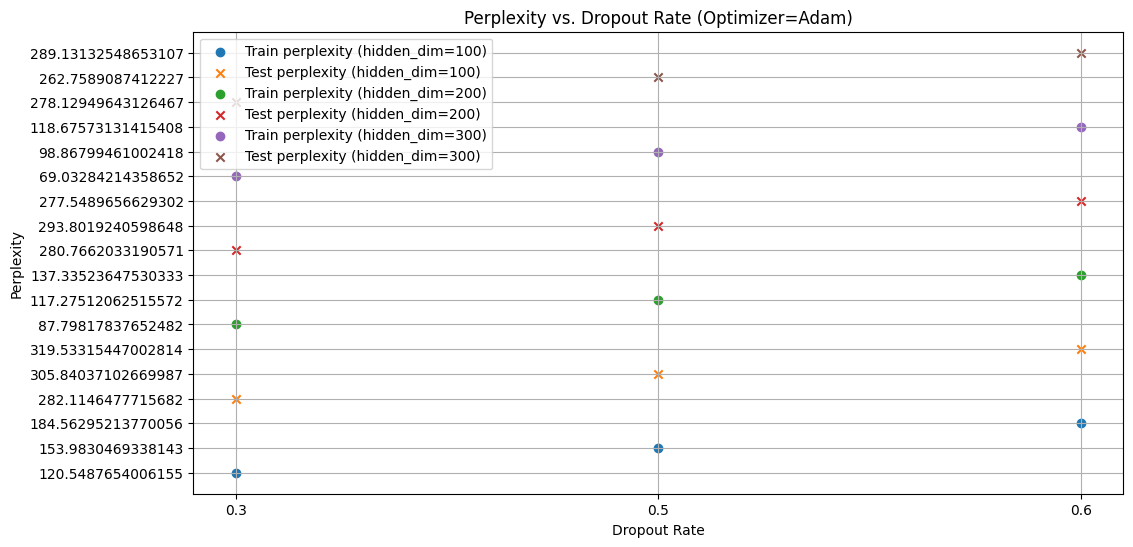

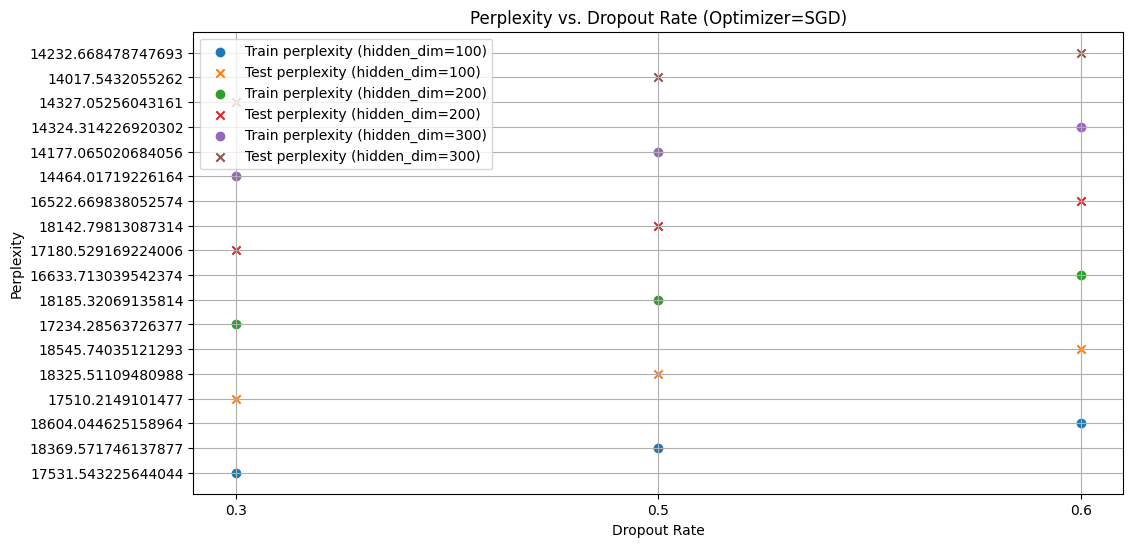

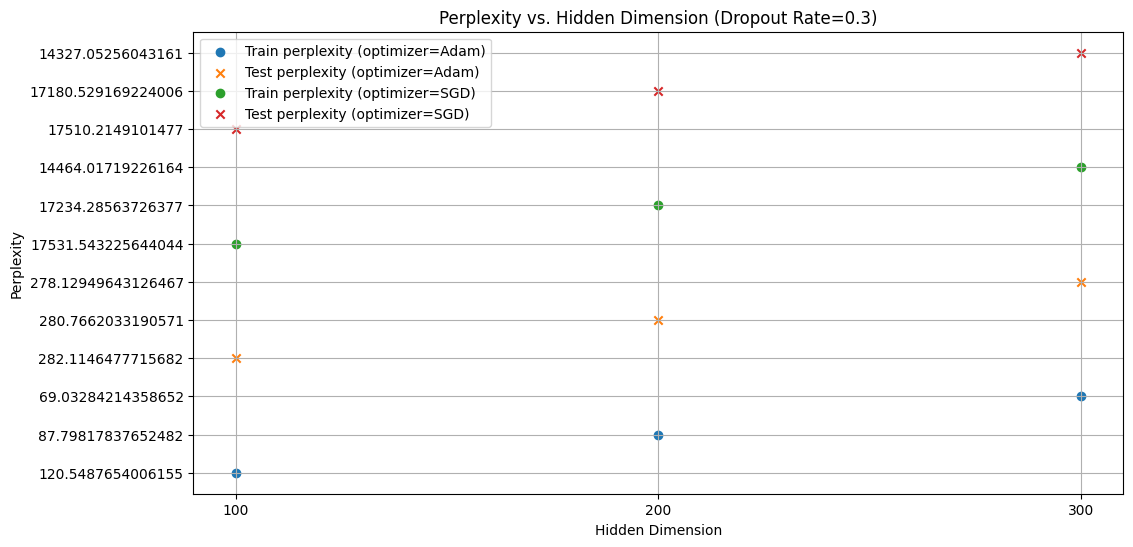

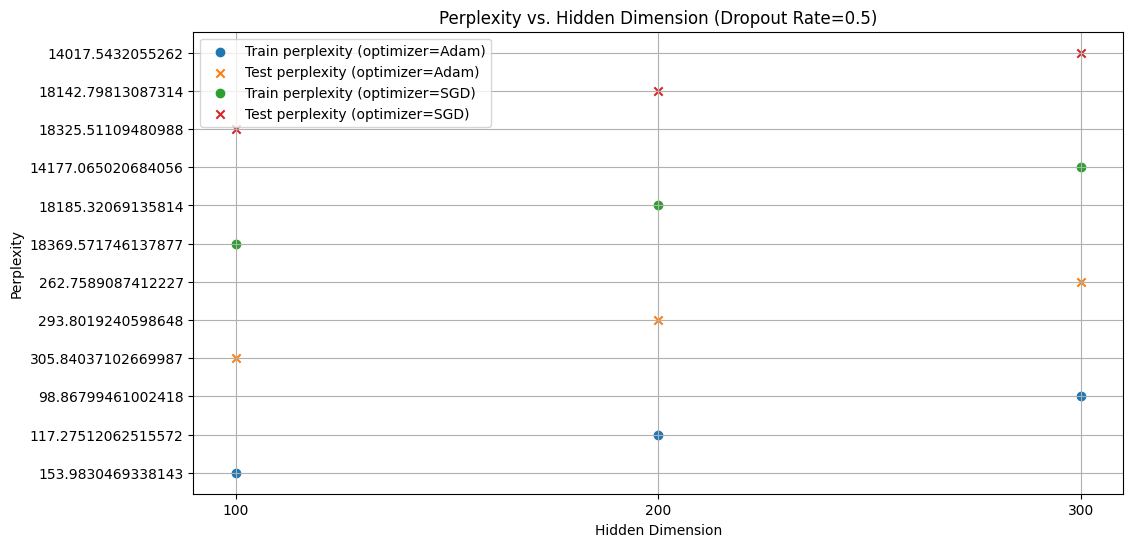

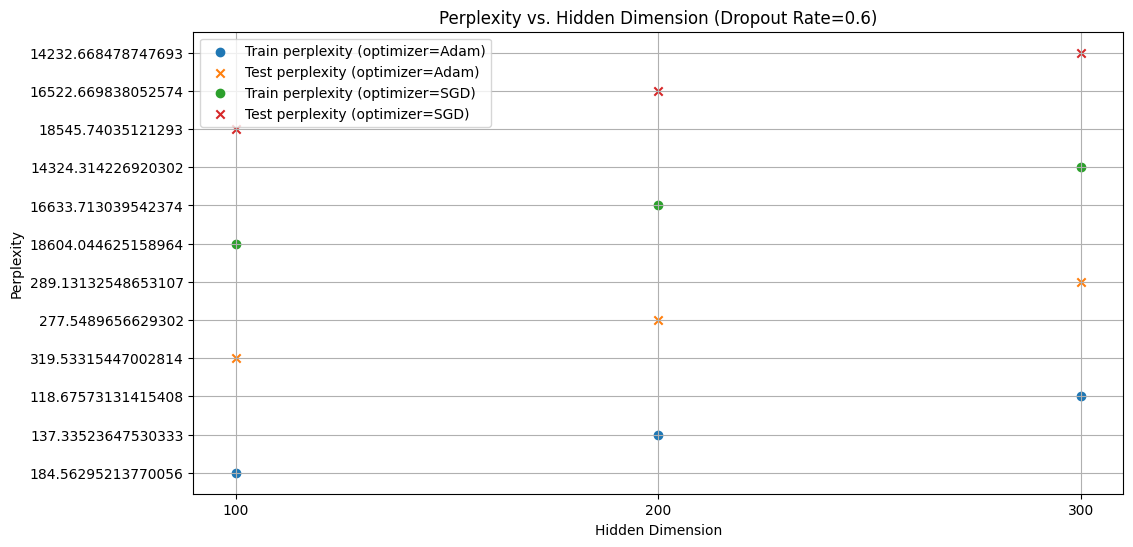

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    # Create an embedding matrix
    embedding_dim = glove_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocab, word_to_idx, idx_to_word, embedding_matrix

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix, dropout_rate):
        super(NeuralLanguageModel, self).__init__()
        
        # Use pre-trained GloVe embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embeddings.weight.requires_grad = False  # Keep the embeddings fixed (non-trainable)

        self.fc1 = nn.Linear(embedding_dim * 5, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, vocab_size)  # Output layer for vocabulary size
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer with variable rate
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embeddings(x)  # Shape: (batch_size, context_size, embedding_dim)
        x = x.view(x.size(0), -1)  # Flatten the embeddings
        x = torch.relu(self.fc1(x))  # First hidden layer
        x = torch.relu(self.fc2(x))  # Second hidden layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)  # Output layer
        x = self.softmax(x)
        return x

# Compute perplexity and print results
def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for context, target in data_loader:
            if context is None:
                continue
            context, target = context.to(device), target.to(device)
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item() * context.size(0)
            total_words += context.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Plot results
def plot_results(results):
    # Convert results to numpy array for easy plotting
    results = np.array(results)
    dropout_rates = np.unique(results[:, 0])
    hidden_dims = np.unique(results[:, 1])
    optimizer_names = np.unique(results[:, 2])

    # Plot perplexity vs. dropout rate for different hidden dimensions and optimizers
    for optimizer_name in optimizer_names:
        plt.figure(figsize=(12, 6))

        for hidden_dim in hidden_dims:
            subset = results[(results[:, 1] == hidden_dim) & (results[:, 2] == optimizer_name)]
            plt.scatter(subset[:, 0], subset[:, 3], label=f'Train perplexity (hidden_dim={hidden_dim})')
            plt.scatter(subset[:, 0], subset[:, 5], label=f'Test perplexity (hidden_dim={hidden_dim})', marker='x')

        plt.title(f'Perplexity vs. Dropout Rate (Optimizer={optimizer_name})')
        plt.xlabel('Dropout Rate')
        plt.ylabel('Perplexity')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot perplexity vs. hidden dimension for different dropout rates and optimizers
    for dropout_rate in dropout_rates:
        plt.figure(figsize=(12, 6))

        for optimizer_name in optimizer_names:
            subset = results[(results[:, 0] == dropout_rate) & (results[:, 2] == optimizer_name)]
            plt.scatter(subset[:, 1], subset[:, 3], label=f'Train perplexity (optimizer={optimizer_name})')
            plt.scatter(subset[:, 1], subset[:, 5], label=f'Test perplexity (optimizer={optimizer_name})', marker='x')

        plt.title(f'Perplexity vs. Hidden Dimension (Dropout Rate={dropout_rate})')
        plt.xlabel('Hidden Dimension')
        plt.ylabel('Perplexity')
        plt.legend()
        plt.grid(True)
        plt.show()

# Main function
def main():
    # Load data
    def load_and_preprocess(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = [line.strip().split() for line in file if line.strip()]  # Don't remove punctuation
        return sentences

    train_sentences = load_and_preprocess('/kaggle/working/train.txt')
    val_sentences = load_and_preprocess('/kaggle/working/val.txt')
    test_sentences = load_and_preprocess('/kaggle/working/test.txt')

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty. Check the input data.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty. Check the input data.")
    if len(test_dataset) == 0:
        raise ValueError("Test dataset is empty. Check the input data.")

    # Hyperparameters to experiment with
    dropout_rates = [0.3, 0.5, 0.6]
    hidden_dims = [100, 200, 300]
    optimizers = {
        'Adam': optim.Adam,
        'SGD': optim.SGD
    }

    results = []

    # Experiment with different hyperparameters
    for dropout_rate in dropout_rates:
        for hidden_dim in hidden_dims:
            for optimizer_name, optimizer_class in optimizers.items():
                print(f"Testing with dropout_rate={dropout_rate}, hidden_dim={hidden_dim}, optimizer={optimizer_name}")

                # Create DataLoader for training, validation, and test
                train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

                # Model, loss function, and optimizer
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model = NeuralLanguageModel(
                    vocab_size=len(vocab),
                    embedding_dim=100,
                    hidden_dim=hidden_dim,
                    embedding_matrix=embedding_matrix,
                    dropout_rate=dropout_rate
                ).to(device)
                criterion = nn.NLLLoss()
                optimizer = optimizer_class(model.parameters(), lr=0.0005)

                # Train the model
                num_epochs = 6
                for epoch in range(num_epochs):
                    model.train()
                    total_loss = 0
                    
                    for context, target in train_loader:
                        context, target = context.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = model(context)
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item() * context.size(0)
                    
                    avg_loss = total_loss / len(train_loader.dataset)
                    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}")

                # Compute perplexity
                train_perplexity = compute_perplexity(model, train_loader, criterion, device)
                val_perplexity = compute_perplexity(model, val_loader, criterion, device)
                test_perplexity = compute_perplexity(model, test_loader, criterion, device)
                
                print(f"Perplexities - Train: {train_perplexity}, Val: {val_perplexity}, Test: {test_perplexity}")

                # Append results for plotting
                results.append([dropout_rate, hidden_dim, optimizer_name, train_perplexity, val_perplexity, test_perplexity])

    # Plot the results
    plot_results(results)

if __name__ == "__main__":
    main()


# LSTM LM with source context pairs context_size=5

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import re
from collections import Counter
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    # Create an embedding matrix
    embedding_dim = glove_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocab, word_to_idx, idx_to_word, embedding_matrix

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.context_size = context_size
        self.data = self.create_context_target_pairs(sentences)

    def create_context_target_pairs(self, sentences):
        data = []
        for sentence in sentences:
            if len(sentence) > self.context_size:
                for i in range(self.context_size, len(sentence)):
                    context = sentence[i-self.context_size:i]
                    target = sentence[i]
                    data.append((context, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

    def collate_fn(self, batch):
        contexts, targets = zip(*batch)
        contexts_padded = pad_sequence([torch.tensor(context) for context in contexts], batch_first=True, padding_value=0)
        targets_tensor = torch.tensor(targets)
        return contexts_padded, targets_tensor

class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super(NeuralLanguageModel, self).__init__()
        
        # Use pre-trained GloVe embeddings
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embeddings.weight.requires_grad = False  # Keep the embeddings fixed (non-trainable)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, dropout=0.5, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% rate
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embeddings(x)  # Shape: (batch_size, seq_length, embedding_dim)
        x, _ = self.lstm(x)  # LSTM layer
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Use the output of the last LSTM cell
        x = self.softmax(x)
        return x

# Compute perplexity and write to file
def compute_perplexity(model, data_loader, criterion, device, file_name):
    model.eval()
    total_loss = 0
    total_words = 0
    batch_num = 0
    
    with open(file_name, "w") as f:
        with torch.no_grad():
            for context, target in data_loader:
                batch_num += 1
                if context is None:
                    continue
                context, target = context.to(device), target.to(device)
                output = model(context)
                loss = criterion(output, target)
                total_loss += loss.item() * context.size(0)
                total_words += context.size(0)

                avg_loss = loss.item()
                perplexity = np.exp(avg_loss)
                f.write(f"Batch {batch_num}: Perplexity = {perplexity:.4f}\n")
    
    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    def load_and_preprocess(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = [line.strip().split() for line in file if line.strip()]  # Don't remove punctuation
        return sentences

    train_sentences = load_and_preprocess('/kaggle/working/train.txt')
    val_sentences = load_and_preprocess('/kaggle/working/val.txt')
    test_sentences = load_and_preprocess('/kaggle/working/test.txt')

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    # Check if datasets are empty
    if len(train_dataset) == 0:
        raise ValueError("Training dataset is empty. Check the input data.")
    if len(val_dataset) == 0:
        raise ValueError("Validation dataset is empty. Check the input data.")
    if len(test_dataset) == 0:
        raise ValueError("Test dataset is empty. Check the input data.")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=val_dataset.collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.collate_fn)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralLanguageModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=300, embedding_matrix=embedding_matrix).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, "2023202005-LM2-train-perplexity.txt")
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, "2023202005-LM2-val-perplexity.txt")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, "2023202005-LM2-test-perplexity.txt")
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


  0%|          | 0/8888 [00:00<?, ?it/s]/tmp/ipykernel_36/3407226052.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contexts_padded = pad_sequence([torch.tensor(context) for context in contexts], batch_first=True, padding_value=0)
100%|██████████| 8888/8888 [00:56<00:00, 157.94it/s]


Epoch 1/10, Loss: 5.7485
Training Perplexity: 194.7133
Validation Perplexity: 216.0761


100%|██████████| 8888/8888 [00:56<00:00, 158.02it/s]


Epoch 2/10, Loss: 5.3308
Training Perplexity: 154.8398
Validation Perplexity: 187.1908


100%|██████████| 8888/8888 [00:56<00:00, 158.46it/s]


Epoch 3/10, Loss: 5.1820
Training Perplexity: 135.7954
Validation Perplexity: 174.9871


100%|██████████| 8888/8888 [00:55<00:00, 158.96it/s]


Epoch 4/10, Loss: 5.0887
Training Perplexity: 123.6686
Validation Perplexity: 167.4965


100%|██████████| 8888/8888 [00:56<00:00, 158.30it/s]


Epoch 5/10, Loss: 5.0198
Training Perplexity: 115.0875
Validation Perplexity: 162.2960


100%|██████████| 8888/8888 [00:56<00:00, 158.36it/s]


Epoch 6/10, Loss: 4.9665
Training Perplexity: 107.2987
Validation Perplexity: 157.0432


100%|██████████| 8888/8888 [00:56<00:00, 158.00it/s]


Epoch 7/10, Loss: 4.9168
Training Perplexity: 101.4608
Validation Perplexity: 154.2215


100%|██████████| 8888/8888 [00:56<00:00, 158.09it/s]


Epoch 8/10, Loss: 4.8774
Training Perplexity: 96.9762
Validation Perplexity: 152.9158


100%|██████████| 8888/8888 [00:56<00:00, 158.62it/s]


Epoch 9/10, Loss: 4.8378
Training Perplexity: 92.2327
Validation Perplexity: 150.0665


100%|██████████| 8888/8888 [00:56<00:00, 157.81it/s]


Epoch 10/10, Loss: 4.8033
Training Perplexity: 88.5994
Validation Perplexity: 149.7456
Test Perplexity: 148.7787


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    vocab.add("<PAD>")
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    embedding_dim = glove_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocab, word_to_idx, idx_to_word, embedding_matrix

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word_to_idx, seq_length=40):
        self.sentences = sentences
        self.word_to_idx = word_to_idx
        self.seq_length = seq_length
        self.data = self.prepare_data()

    def prepare_data(self):
        data = []
        pad_idx = self.word_to_idx["<PAD>"]
        for sentence in self.sentences:
            if len(sentence) > 1:  # Ensure the sentence has at least 2 words
                indexed_sentence = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in sentence]
                
                # Pad or truncate the sentence to seq_length + 1
                if len(indexed_sentence) < self.seq_length + 1:
                    indexed_sentence = indexed_sentence + [pad_idx] * (self.seq_length + 1 - len(indexed_sentence))
                else:
                    indexed_sentence = indexed_sentence[:self.seq_length + 1]
                
                # Create input-target pairs
                seq = indexed_sentence[:self.seq_length]
                target = indexed_sentence[1:self.seq_length + 1]
                
                data.append((seq, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, target = self.data[idx]
        return torch.tensor(seq), torch.tensor(target)

class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super(NeuralLanguageModel, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embeddings.weight.requires_grad = False

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.embeddings(x)  # Shape: (batch_size, seq_length, embedding_dim)
        x, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_dim)
        x = self.dropout(x)
        x = self.fc(x)  # Shape: (batch_size, seq_length, vocab_size)
        return x

def compute_perplexity(model, data_loader, criterion, device, file_name, is_train=False):
    model.eval()
    total_loss = 0
    total_words = 0
    batch_perplexities = []
    
    with open(file_name, "w") as f:
        with torch.no_grad():
            for batch_num, (seq, target) in enumerate(data_loader, 1):
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output.view(-1, output.size(-1)), target.view(-1))
                
                non_pad_elements = (target != 0).sum().item()
                batch_loss = loss.item() * non_pad_elements
                total_loss += batch_loss
                total_words += non_pad_elements

                batch_perplexity = np.exp(batch_loss / non_pad_elements)
                batch_perplexities.append(batch_perplexity)
                
                if is_train:
                    f.write(f"Batch {batch_num}: Perplexity = {batch_perplexity:.4f}\n")
                else:
                    f.write(f"Batch {batch_num}: Perplexity = {batch_perplexity:.4f}\n")
        
        if is_train:
            avg_perplexity = np.mean(batch_perplexities)
            f.write(f"\nAverage Perplexity: {avg_perplexity:.4f}\n")
            return avg_perplexity
        else:
            avg_loss = total_loss / total_words
            avg_perplexity = np.exp(avg_loss)
            return avg_perplexity

def main():
    def load_and_preprocess(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            sentences = [line.strip().split() for line in file if line.strip()]
        return sentences

    train_sentences = load_and_preprocess('/kaggle/working/train.txt')
    val_sentences = load_and_preprocess('/kaggle/working/val.txt')
    test_sentences = load_and_preprocess('/kaggle/working/test.txt')

    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

    train_dataset = LanguageModelDataset(train_sentences, word_to_idx)
    val_dataset = LanguageModelDataset(val_sentences, word_to_idx)
    test_dataset = LanguageModelDataset(test_sentences, word_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralLanguageModel(vocab_size=len(vocab), embedding_dim=100, hidden_dim=300, embedding_matrix=embedding_matrix).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for seq, target in tqdm(train_loader):
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output.view(-1, output.size(-1)), target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * seq.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity for training set after each epoch
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, "2023202005-LM2-train-perplexity.txt", is_train=True)
        print(f"Epoch {epoch + 1} Training Perplexity: {train_perplexity:.4f}")

        # Compute perplexity for validation set after each epoch
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, "2023202005-LM2-val-perplexity.txt")
        print(f"Epoch {epoch + 1} Validation Perplexity: {val_perplexity:.4f}")

    # Compute perplexity for test set after training
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, "2023202005-LM2-test-perplexity.txt")
    print(f"Final Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


100%|██████████| 529/529 [00:25<00:00, 20.52it/s]


Epoch 1/10, Loss: 6.1560
Epoch 1 Training Perplexity: 265.1210
Epoch 1 Validation Perplexity: 264.4561


 78%|███████▊  | 412/529 [00:20<00:05, 20.27it/s]


KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        for layer in self.layers:
            src = layer(src, mask)
        output = self.fc_out(src)
        return output

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]  # Shift by 1 for next word prediction
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item() * tgt.size(0)
            total_words += tgt.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    return perplexity

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 256
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.1

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training and validation sets
        train_perplexity = compute_perplexity(model, train_loader, criterion, device)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device)
        print(f"Training Perplexity: {train_perplexity:.4f}")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()

Epoch 1/10: 100%|██████████| 1058/1058 [00:13<00:00, 78.05it/s]


Epoch 1/10, Loss: 15.1104
Training Perplexity: 15555.1068
Validation Perplexity: 41860.6979


Epoch 2/10: 100%|██████████| 1058/1058 [00:13<00:00, 80.97it/s]


Epoch 2/10, Loss: 8.8276
Training Perplexity: 1450.7736
Validation Perplexity: 6711.3232


Epoch 3/10: 100%|██████████| 1058/1058 [00:13<00:00, 79.88it/s]


Epoch 3/10, Loss: 7.1049
Training Perplexity: 445.5578
Validation Perplexity: 2980.6629


Epoch 4/10: 100%|██████████| 1058/1058 [00:13<00:00, 77.66it/s]


Epoch 4/10, Loss: 6.1442
Training Perplexity: 222.3912
Validation Perplexity: 1910.4255


Epoch 5/10: 100%|██████████| 1058/1058 [00:13<00:00, 78.85it/s]


Epoch 5/10, Loss: 5.5374
Training Perplexity: 138.1594
Validation Perplexity: 1406.2616


Epoch 6/10: 100%|██████████| 1058/1058 [00:13<00:00, 79.01it/s]


Epoch 6/10, Loss: 5.1314
Training Perplexity: 100.3070
Validation Perplexity: 1153.5437


Epoch 7/10: 100%|██████████| 1058/1058 [00:13<00:00, 79.37it/s]


Epoch 7/10, Loss: 4.8430
Training Perplexity: 78.8865
Validation Perplexity: 1006.0034


Epoch 8/10: 100%|██████████| 1058/1058 [00:13<00:00, 78.29it/s]


Epoch 8/10, Loss: 4.6245
Training Perplexity: 65.5652
Validation Perplexity: 914.2339


Epoch 9/10: 100%|██████████| 1058/1058 [00:13<00:00, 76.92it/s]


Epoch 9/10, Loss: 4.4576
Training Perplexity: 56.5487
Validation Perplexity: 858.7974


Epoch 10/10: 100%|██████████| 1058/1058 [00:13<00:00, 76.34it/s]


Epoch 10/10, Loss: 4.3181
Training Perplexity: 49.6717
Validation Perplexity: 807.6600
Test Perplexity: 729.6506


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory_mask=None, tgt_mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=tgt_mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout),
            num_layers
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_padding_mask=None, tgt_mask=None):
        src = self.embedding(src)
        tgt = src  # In this case, we use src as both src and tgt (for demonstration)

        # Create masks if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        if src_padding_mask is None:
            src_padding_mask = torch.zeros(src.size(1), src.size(1)).bool().to(src.device)

        output = self.transformer_decoder(tgt, src, memory_key_padding_mask=src_padding_mask, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word_to_idx, context_size=5, pad_idx=0):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def pad_sequences(sequences, pad_idx, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_sequences, dtype=torch.long)

def compute_perplexity(model, data_loader, criterion, device,pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Add padding index
    pad_idx = word_to_idx.get("<UNK>")

    # Pad sequences
    train_indices = pad_sequences(train_indices, pad_idx)
    val_indices = pad_sequences(val_indices, pad_idx)
    test_indices = pad_sequences(test_indices, pad_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices, word_to_idx, pad_idx=pad_idx)
    val_dataset = LanguageModelDataset(val_indices, word_to_idx, pad_idx=pad_idx)
    test_dataset = LanguageModelDataset(test_indices, word_to_idx, pad_idx=pad_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 256
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.1
    pad_idx = 0  # Padding index


    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        perplexity = compute_perplexity(model, val_loader, criterion, device, pad_idx)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Perplexity: {perplexity:.4f}")

    # Save model
    torch.save(model.state_dict(), "transformer_decoder.pt")

    # Load model for evaluation
    model.load_state_dict(torch.load("transformer_decoder.pt"))
    model.eval()
    test_perplexity = compute_perplexity(model, test_loader, criterion, device)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Epoch 1/10:   0%|          | 0/1058 [00:00<?, ?it/s]/tmp/ipykernel_36/3167116981.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)
Epoch 1/10: 100%|██████████| 1058/1058 [00:18<00:00, 55.99it/s]


Epoch 1/10, Loss: 3.6842, Val Perplexity: 15.7943


Epoch 2/10: 100%|██████████| 1058/1058 [00:19<00:00, 55.08it/s]


Epoch 2/10, Loss: 2.2541, Val Perplexity: 11.4965


Epoch 3/10: 100%|██████████| 1058/1058 [00:19<00:00, 54.40it/s]


Epoch 3/10, Loss: 1.7552, Val Perplexity: 11.2450


Epoch 4/10: 100%|██████████| 1058/1058 [00:20<00:00, 52.65it/s]


Epoch 4/10, Loss: 1.4874, Val Perplexity: 11.6565


Epoch 5/10: 100%|██████████| 1058/1058 [00:19<00:00, 55.02it/s]


Epoch 5/10, Loss: 1.3608, Val Perplexity: 12.5232


Epoch 6/10: 100%|██████████| 1058/1058 [00:18<00:00, 56.64it/s]


Epoch 6/10, Loss: 1.3173, Val Perplexity: 12.9179


Epoch 7/10: 100%|██████████| 1058/1058 [00:19<00:00, 55.52it/s]


Epoch 7/10, Loss: 1.2904, Val Perplexity: 13.3052


Epoch 8/10: 100%|██████████| 1058/1058 [00:19<00:00, 54.65it/s]


Epoch 8/10, Loss: 1.2549, Val Perplexity: 13.3534


Epoch 9/10: 100%|██████████| 1058/1058 [00:18<00:00, 55.94it/s]


Epoch 9/10, Loss: 1.2209, Val Perplexity: 13.6176


Epoch 10/10: 100%|██████████| 1058/1058 [00:19<00:00, 53.15it/s]


Epoch 10/10, Loss: 1.2114, Val Perplexity: 14.1025


/tmp/ipykernel_36/3167116981.py:202: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_decoder.pt"))


TypeError: compute_perplexity() missing 1 required positional argument: 'pad_idx'

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory_mask=None, tgt_mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=tgt_mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout),
            num_layers
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_padding_mask=None, tgt_mask=None):
        src = self.embedding(src)
        tgt = src  # In this case, we use src as both src and tgt (for demonstration)

        # Create masks if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        if src_padding_mask is None:
            src_padding_mask = torch.zeros(src.size(1), src.size(1)).bool().to(src.device)

        output = self.transformer_decoder(tgt, src, memory_key_padding_mask=src_padding_mask, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word_to_idx, context_size=5, pad_idx=0):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")  # For unknown words
    vocab.add("<PAD>")  # For padding
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word


def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def pad_sequences(sequences, pad_idx, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_sequences, dtype=torch.long)

def compute_perplexity(model, data_loader, criterion, device, pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Add padding index
    pad_idx = word_to_idx.get("<PAD>")  # Correctly get the padding index

    # Pad sequences
    train_indices = pad_sequences(train_indices, pad_idx)
    val_indices = pad_sequences(val_indices, pad_idx)
    test_indices = pad_sequences(test_indices, pad_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices, word_to_idx, pad_idx=pad_idx)
    val_dataset = LanguageModelDataset(val_indices, word_to_idx, pad_idx=pad_idx)
    test_dataset = LanguageModelDataset(test_indices, word_to_idx, pad_idx=pad_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 256
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.1

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 4
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, pad_idx)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, pad_idx)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Val Perplexity: {val_perplexity:.4f}")

    # Save model
    torch.save(model.state_dict(), "transformer_decoder.pt")

    # Evaluate on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, pad_idx)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Epoch 1/4:   0%|          | 0/1058 [00:00<?, ?it/s]/tmp/ipykernel_36/206659606.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)
Epoch 1/4: 100%|██████████| 1058/1058 [00:19<00:00, 54.20it/s]


Epoch 1/4, Train Loss: 3.6795, Train Perplexity: 8.5655, Val Perplexity: 15.8006


Epoch 2/4: 100%|██████████| 1058/1058 [00:19<00:00, 55.51it/s]


Epoch 2/4, Train Loss: 2.2453, Train Perplexity: 4.2638, Val Perplexity: 11.6119


Epoch 3/4: 100%|██████████| 1058/1058 [00:19<00:00, 54.36it/s]


Epoch 3/4, Train Loss: 1.7493, Train Perplexity: 3.1631, Val Perplexity: 11.3980


Epoch 4/4: 100%|██████████| 1058/1058 [00:18<00:00, 56.11it/s]


Epoch 4/4, Train Loss: 1.4849, Train Perplexity: 2.8677, Val Perplexity: 12.3838
Test Perplexity: 12.2444


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory_mask=None, tgt_mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=tgt_mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout),
            num_layers
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_padding_mask=None, tgt_mask=None):
        src = self.embedding(src)
        src = self.positional_encoding(src)
        tgt = src  # In this case, we use src as both src and tgt (for demonstration)

        # Create masks if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        if src_padding_mask is None:
            src_padding_mask = torch.zeros(src.size(1), src.size(1)).bool().to(src.device)

        output = self.transformer_decoder(tgt, src, memory_key_padding_mask=src_padding_mask, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word_to_idx, pad_idx=0):
        self.sentences = [s for s in sentences if len(s) > 1]  # Ensure sentences have more than 1 token
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:-1]  # All tokens except the last one
        target = sentence[1:]   # All tokens except the first one
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")  # For unknown words
    vocab.add("<PAD>")  # For padding
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def pad_sequences(sequences, pad_idx, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_sequences, dtype=torch.long)

def compute_perplexity(model, data_loader, criterion, device, pad_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Add padding index
    pad_idx = word_to_idx.get("<PAD>")  # Correctly get the padding index

    # Pad sequences
    train_indices = pad_sequences(train_indices, pad_idx)
    val_indices = pad_sequences(val_indices, pad_idx)
    test_indices = pad_sequences(test_indices, pad_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices, word_to_idx, pad_idx=pad_idx)
    val_dataset = LanguageModelDataset(val_indices, word_to_idx, pad_idx=pad_idx)
    test_dataset = LanguageModelDataset(test_indices, word_to_idx, pad_idx=pad_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 256
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.1

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 4
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1), src_padding_mask=(src == pad_idx))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, pad_idx)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, pad_idx)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Perplexity = {train_perplexity:.4f}, Val Perplexity = {val_perplexity:.4f}")

    # Test perplexity
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, pad_idx)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Epoch 1/4:   0%|          | 0/1058 [00:00<?, ?it/s]/tmp/ipykernel_36/676433463.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)
Epoch 1/4: 100%|██████████| 1058/1058 [07:01<00:00,  2.51it/s]


Epoch 1: Train Loss = 2.5270, Train Perplexity = 1.7918, Val Perplexity = 2.3060


Epoch 2/4: 100%|██████████| 1058/1058 [07:05<00:00,  2.49it/s]


Epoch 2: Train Loss = 0.5398, Train Perplexity = 1.2171, Val Perplexity = 1.7159


Epoch 3/4: 100%|██████████| 1058/1058 [07:05<00:00,  2.49it/s]


Epoch 3: Train Loss = 0.2488, Train Perplexity = 1.1259, Val Perplexity = 1.6482


Epoch 4/4: 100%|██████████| 1058/1058 [07:05<00:00,  2.49it/s]


Epoch 4: Train Loss = 0.1617, Train Perplexity = 1.0958, Val Perplexity = 1.6486
Test Perplexity: 1.6095


## import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import gensim.downloader as api

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        for layer in self.layers:
            src = layer(src, mask)
        output = self.fc_out(src)
        return output

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word_to_idx, fixed_length=40, pad_idx=0):
        self.sentences = [s for s in sentences if len(s) > 0]  # Filter out empty sentences
        self.word_to_idx = word_to_idx
        self.fixed_length = fixed_length
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # Convert words to indices
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in sentence]

        # Pad or truncate to fixed length
        if len(indices) < self.fixed_length:
            indices += [self.pad_idx] * (self.fixed_length - len(indices))  # Padding
        else:
            indices = indices[:self.fixed_length]  # Truncation

        # Prepare context and target
        context = indices[:-1]  # All but the last word
        target = indices[1:]    # All but the first word
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")  # For unknown words
    vocab.add("<PAD>")  # For padding
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def compute_perplexity(model, data_loader, criterion, device, pad_idx, output_file=None):
    model.eval()
    total_loss = 0
    batch_perplexities = []

    with torch.no_grad():
        for batch_idx, (src, tgt) in enumerate(data_loader):
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item()
            perplexity = torch.exp(torch.tensor(loss.item())).item()
            batch_perplexities.append((batch_idx, perplexity))

    avg_loss = total_loss / len(data_loader)
    avg_perplexity = torch.exp(torch.tensor(avg_loss)).item()

    if output_file:
        with open(output_file, 'w') as f:
            for batch_idx, perplexity in batch_perplexities:
                f.write(f"Batch {batch_idx}: {perplexity:.4f}\n")

    return avg_perplexity, batch_perplexities

def main():
    # Load GloVe embeddings
    glove_model = load_glove_embeddings()

    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Create datasets
    fixed_length = 40  # Set the fixed length for sentences
    pad_idx = word_to_idx.get("<PAD>")  # Correctly get the padding index

    train_dataset = LanguageModelDataset(train_sentences, word_to_idx, fixed_length, pad_idx)
    val_dataset = LanguageModelDataset(val_sentences, word_to_idx, fixed_length, pad_idx)
    test_dataset = LanguageModelDataset(test_sentences, word_to_idx, fixed_length, pad_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 100
    nhead = 5
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.2

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 6
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_perplexity, _ = compute_perplexity(model, train_loader, criterion, device, pad_idx, "2023202005-LM3-train-perplexity.txt")
        val_perplexity, _ = compute_perplexity(model, val_loader, criterion, device, pad_idx, "2023202005-LM3-val-perplexity.txt")
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, Val Perplexity: {val_perplexity:.4f}")

    # Evaluate on test set
    test_perplexity, _ = compute_perplexity(model, test_loader, criterion, device, pad_idx, "2023202005-LM3-test-perplexity.txt")
    print(f"Test Perplexity: {test_perplexity:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "transformer_decoder.pth")
    print("Model saved as 'transformer_decoder.pth'")

if __name__ == "__main__":
    main()


In [18]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# import gensim.downloader as api
# from tqdm import tqdm
# from torch.nn.utils.rnn import pad_sequence
# import math

# # Set random seed for reproducibility
# torch.manual_seed(0)
# np.random.seed(0)

# # Load GloVe embeddings
# def load_glove_embeddings():
#     print("Loading GloVe embeddings...")
#     glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
#     return glove_model

# # Prepare vocabulary and index mapping
# def build_vocab(sentences, glove_model):
#     vocab = set()
#     for sentence in sentences:
#         vocab.update(sentence)
    
#     # Add <PAD> and <UNK> tokens
#     vocab.add("<PAD>")
#     vocab.add("<UNK>")
#     word_to_idx = {word: idx for idx, word in enumerate(vocab)}
#     idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
#     # Create an embedding matrix
#     embedding_dim = glove_model.vector_size
#     embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
#     for word, idx in word_to_idx.items():
#         if word in glove_model:
#             embedding_matrix[idx] = glove_model[word]
#         else:
#             embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

#     return vocab, word_to_idx, idx_to_word, embedding_matrix

# # Convert sentences to indices
# def sentences_to_indices(sentences, word_to_idx):
#     return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# # Define Dataset class
# class LanguageModelDataset(Dataset):
#     def __init__(self, sentences, word_to_idx, context_size=5):
#         self.sentences = [s for s in sentences if len(s) >= context_size + 1]
#         self.word_to_idx = word_to_idx
#         self.context_size = context_size

#     def __len__(self):
#         return len(self.sentences)

#     def __getitem__(self, idx):
#         sentence = self.sentences[idx]
#         context = sentence[:self.context_size]
#         target = sentence[self.context_size]
#         return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

#     def collate_fn(self, batch):
#         contexts, targets = zip(*batch)
#         contexts_padded = pad_sequence(contexts, batch_first=True, padding_value=self.word_to_idx["<PAD>"])
#         targets = torch.stack(targets)
#         return contexts_padded, targets

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return x + self.pe[:x.size(0), :]

# class TransformerDecoderLayer(nn.Module):
#     def __init__(self, d_model, nhead, dim_feedforward, dropout):
#         super(TransformerDecoderLayer, self).__init__()
#         self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
#         self.feed_forward = nn.Sequential(
#             nn.Linear(d_model, dim_feedforward),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(dim_feedforward, d_model)
#         )
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, mask):
#         # Self-attention
#         x = x.transpose(0, 1)  # Change to (seq_len, batch, feature)
#         attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
#         x = x + self.dropout(attn_output)
#         x = self.norm1(x)
        
#         # Feedforward
#         ff_output = self.feed_forward(x)
#         x = x + self.dropout(ff_output)
#         x = self.norm2(x)
        
#         return x.transpose(0, 1)  # Change back to (batch, seq_len, feature)

# class TransformerLanguageModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, nhead, nhid, nlayers, dropout=0.5):
#         super(TransformerLanguageModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.pos_encoder = PositionalEncoding(embedding_dim)
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.transformer_layers = nn.ModuleList([
#             TransformerDecoderLayer(embedding_dim, nhead, nhid, dropout)
#             for _ in range(nlayers)
#         ])
#         self.fc_out = nn.Linear(embedding_dim, vocab_size)

#         self.embedding_dim = embedding_dim

#     def generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def forward(self, src):
#         src = self.embedding(src) * math.sqrt(self.embedding_dim)
#         src = self.pos_encoder(src)
        
#         mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)
        
#         for layer in self.transformer_layers:
#             src = layer(src, mask)
        
#         output = self.fc_out(src)
#         return output

# # Compute perplexity and write to file
# def compute_perplexity(model, data_loader, criterion, device, file_name):
#     model.eval()
#     total_loss = 0
#     total_words = 0
#     batch_num = 0
    
#     with open(file_name, "w") as f:
#         with torch.no_grad():
#             for context, target in data_loader:
#                 batch_num += 1
#                 if context is None:
#                     continue
#                 context, target = context.to(device), target.to(device)
#                 output = model(context)
                
#                 # Reshape the output tensor
#                 output = output.view(-1, output.size(-1))  # (batch_size * seq_len, vocab_size)
#                 target = target.view(-1)  # (batch_size * seq_len)
#                 loss = criterion(output, target)
#                 total_loss += loss.item() * context.size(0)
#                 total_words += context.size(0)

#                 avg_loss = loss.item()
#                 perplexity = np.exp(avg_loss)
#                 f.write(f"Batch {batch_num}: Perplexity = {perplexity:.4f}\n")
    
#     avg_loss = total_loss / total_words
#     perplexity = np.exp(avg_loss)
#     return perplexity

# # Main function
# def main():
#     # Load data
#     def load_and_preprocess(file_path):
#         with open(file_path, 'r', encoding='utf-8') as file:
#             sentences = [line.strip().split() for line in file if line.strip()]  # Don't remove punctuation
#         return sentences

#     train_sentences = load_and_preprocess('/kaggle/working/train.txt')
#     val_sentences = load_and_preprocess('/kaggle/working/val.txt')
#     test_sentences = load_and_preprocess('/kaggle/working/test.txt')

#     # Load embeddings
#     glove_model = load_glove_embeddings()
#     vocab, word_to_idx, idx_to_word, embedding_matrix = build_vocab(train_sentences, glove_model)

#     # Convert sentences to indices
#     train_indices = sentences_to_indices(train_sentences, word_to_idx)
#     val_indices = sentences_to_indices(val_sentences, word_to_idx)
#     test_indices = sentences_to_indices(test_sentences, word_to_idx)

#     # Create datasets and dataloaders
#     train_dataset = LanguageModelDataset(train_indices, word_to_idx)
#     val_dataset = LanguageModelDataset(val_indices, word_to_idx)
#     test_dataset = LanguageModelDataset(test_indices, word_to_idx)

#     # Check if datasets are empty
#     if len(train_dataset) == 0:
#         raise ValueError("Training dataset is empty. Check the input data.")
#     if len(val_dataset) == 0:
#         raise ValueError("Validation dataset is empty. Check the input data.")
#     if len(test_dataset) == 0:
#         raise ValueError("Test dataset is empty. Check the input data.")

#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
#     val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=val_dataset.collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=test_dataset.collate_fn)

#     # Initialize model, criterion, and optimizer
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = TransformerLanguageModel(vocab_size=len(word_to_idx), embedding_dim=100, nhead=2, nhid=200, nlayers=2, dropout=0.5)
#     model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())
#     model.to(device)

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # Training loop
#     num_epochs = 10
#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for context, target in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#             context, target = context.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(context)
#             output = output.view(-1, output.size(-1))
#             target = target.view(-1)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item() * context.size(0)
        
#         avg_loss = epoch_loss / len(train_loader.dataset)
#         perplexity = np.exp(avg_loss)
#         print(f"Epoch {epoch+1}: Train Perplexity = {perplexity:.4f}")

#         # Validation perplexity
#         val_perplexity = compute_perplexity(model, val_loader, criterion, device, f"/kaggle/working/val_perplexity_{epoch+1}.txt")
#         print(f"Epoch {epoch+1}: Validation Perplexity = {val_perplexity:.4f}")

#     # Test perplexity
#     test_perplexity = compute_perplexity(model, test_loader, criterion, device, "/kaggle/working/test_perplexity.txt")
#     print(f"Test Perplexity = {test_perplexity:.4f}")

# if __name__ == "__main__":
#     main()


# Transformer model with positional encoding 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        for layer in self.layers:
            src = layer(src, mask)
        output = self.fc_out(src)
        return output

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]  # Shift by 1 for next word prediction
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item() * tgt.size(0)
            total_words += tgt.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    return perplexity

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 256
    nhead = 8
    num_layers = 3
    dim_feedforward = 512
    dropout = 0.1

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training and validation sets
        train_perplexity = compute_perplexity(model, train_loader, criterion, device)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device)
        print(f"Training Perplexity: {train_perplexity:.4f}")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()

Epoch 1/5: 100%|██████████| 1002/1002 [00:13<00:00, 74.48it/s]


Epoch 1/5, Loss: 9.8601
Training Perplexity: 280.2534
Validation Perplexity: 832.1837


Epoch 2/5: 100%|██████████| 1002/1002 [00:13<00:00, 75.73it/s]


Epoch 2/5, Loss: 5.5970
Training Perplexity: 94.8700
Validation Perplexity: 250.0853


Epoch 3/5: 100%|██████████| 1002/1002 [00:13<00:00, 74.05it/s]


Epoch 3/5, Loss: 4.8947
Training Perplexity: 65.5365
Validation Perplexity: 196.8962


Epoch 4/5: 100%|██████████| 1002/1002 [00:13<00:00, 76.54it/s]


Epoch 4/5, Loss: 4.6842
Training Perplexity: 56.1573
Validation Perplexity: 189.1684


Epoch 5/5: 100%|██████████| 1002/1002 [00:13<00:00, 75.33it/s]


Epoch 5/5, Loss: 4.5839
Training Perplexity: 49.9705
Validation Perplexity: 186.4351
Test Perplexity: 193.2062


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import gensim.downloader as api

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1, use_glove=False, glove_model=None):
        super(TransformerDecoder, self).__init__()
        self.use_glove = use_glove
        if use_glove:
            # Initialize embeddings with GloVe
            embedding_matrix = self.create_embedding_matrix(vocab_size, d_model, glove_model)
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def create_embedding_matrix(self, vocab_size, d_model, glove_model):
        embedding_matrix = torch.zeros((vocab_size, d_model))
        for i in range(vocab_size):
            word = idx_to_word[i]
            if word in glove_model:
                embedding_matrix[i] = torch.tensor(glove_model[word])
            else:
                embedding_matrix[i] = torch.randn(d_model)
        return embedding_matrix

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        for layer in self.layers:
            src = layer(src, mask)
        output = self.fc_out(src)
        return output

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]  # Shift by 1 for next word prediction
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item() * tgt.size(0)
            total_words += tgt.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    return perplexity

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    global vocab, word_to_idx, idx_to_word
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 100  # Match GloVe dimensions
    nhead = 4  # Reduced from 8 to match smaller d_model
    num_layers = 3
    dim_feedforward = 256  # Reduced from 512 to match smaller d_model
    dropout = 0.1
    use_glove = True  # Set to False if you don't want to use GloVe embeddings

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if use_glove:
        glove_model = load_glove_embeddings()
        model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, use_glove=True, glove_model=glove_model).to(device)
    else:
        model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training and validation sets
        train_perplexity = compute_perplexity(model, train_loader, criterion, device)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device)
        print(f"Training Perplexity: {train_perplexity:.4f}")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()

Loading GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded


Epoch 1/5: 100%|██████████| 1002/1002 [00:10<00:00, 92.81it/s]


Epoch 1/5, Loss: 5.6606
Training Perplexity: 86.2721
Validation Perplexity: 142.9654


Epoch 2/5: 100%|██████████| 1002/1002 [00:10<00:00, 94.47it/s]


Epoch 2/5, Loss: 4.5317
Training Perplexity: 54.1983
Validation Perplexity: 124.4274


Epoch 3/5: 100%|██████████| 1002/1002 [00:10<00:00, 95.77it/s]


Epoch 3/5, Loss: 4.1928
Training Perplexity: 41.6587
Validation Perplexity: 125.5864


Epoch 4/5: 100%|██████████| 1002/1002 [00:10<00:00, 94.59it/s]


Epoch 4/5, Loss: 3.9723
Training Perplexity: 33.7316
Validation Perplexity: 126.5482


Epoch 5/5: 100%|██████████| 1002/1002 [00:11<00:00, 90.38it/s]


Epoch 5/5, Loss: 3.7949
Training Perplexity: 28.0141
Validation Perplexity: 131.9066
Test Perplexity: 136.2560


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import gensim.downloader as api

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2, attn_mask=mask)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.feed_forward(x2))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1, use_glove=False, glove_model=None):
        super(TransformerDecoder, self).__init__()
        self.use_glove = use_glove
        if use_glove:
            # Initialize embeddings with GloVe
            embedding_matrix = self.create_embedding_matrix(vocab_size, d_model, glove_model)
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def create_embedding_matrix(self, vocab_size, d_model, glove_model):
        embedding_matrix = torch.zeros((vocab_size, d_model))
        for i in range(vocab_size):
            word = idx_to_word[i]
            if word in glove_model:
                embedding_matrix[i] = torch.tensor(glove_model[word])
            else:
                embedding_matrix[i] = torch.randn(d_model)
        return embedding_matrix

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mask = self.generate_square_subsequent_mask(src.size(0)).to(src.device)
        for layer in self.layers:
            src = layer(src, mask)
        output = self.fc_out(src)
        return output

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[1:self.context_size+1]  # Shift by 1 for next word prediction
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocab, word_to_idx, idx_to_word

def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            total_loss += loss.item() * tgt.size(0)
            total_words += tgt.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    return perplexity

def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Build vocabulary
    global vocab, word_to_idx, idx_to_word
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    train_dataset = LanguageModelDataset(train_indices)
    val_dataset = LanguageModelDataset(val_indices)
    test_dataset = LanguageModelDataset(test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model parameters
    vocab_size = len(vocab)
    d_model = 100  # Match GloVe dimensions
    nhead = 4  # Reduced from 8 to match smaller d_model
    num_layers = 3
    dim_feedforward = 256  # Reduced from 512 to match smaller d_model
    dropout = 0.1
    use_glove = True  # Set to False if you don't want to use GloVe embeddings

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if use_glove:
        glove_model = load_glove_embeddings()
        model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, use_glove=True, glove_model=glove_model).to(device)
    else:
        model = TransformerDecoder(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 2
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for src, tgt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src.transpose(0, 1))
            output = output.transpose(0, 1).contiguous().view(-1, output.size(-1))
            tgt = tgt.contiguous().view(-1)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training and validation sets
        train_perplexity = compute_perplexity(model, train_loader, criterion, device)
        val_perplexity = compute_perplexity(model, val_loader, criterion, device)
        print(f"Training Perplexity: {train_perplexity:.4f}")
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()

Loading GloVe embeddings...


Epoch 1/2: 100%|██████████| 1002/1002 [00:10<00:00, 94.32it/s]


Epoch 1/2, Loss: 5.6606
Training Perplexity: 86.2721
Validation Perplexity: 142.9654


Epoch 2/2: 100%|██████████| 1002/1002 [00:10<00:00, 92.48it/s]


Epoch 2/2, Loss: 4.5317
Training Perplexity: 54.1983
Validation Perplexity: 124.4274
Test Perplexity: 126.9135


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gensim.downloader as api

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings (100-dimensional)
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return vocab, word_to_idx, idx_to_word

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Decoder-based language model
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, max_len, dropout):
        super(TransformerLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.d_model = d_model

    def forward(self, context, target_mask):
        # Embedding and positional encoding
        context = self.embedding(context) * np.sqrt(self.d_model)
        context = self.pos_encoder(context)
        
        # Pass through the Transformer Decoder
        context = context.transpose(0, 1)  # Shape required: (sequence_length, batch_size, embedding_dim)
        output = self.transformer_decoder(context, context, tgt_mask=target_mask)
        
        # Final linear layer and softmax
        output = self.fc_out(output)
        return self.softmax(output.transpose(0, 1))

# Create target mask (for autoregressive decoding)
def generate_square_subsequent_mask(size):
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Compute perplexity
def compute_perplexity(model, data_loader, criterion, device, context_size):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for context, target in data_loader:
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)
            output = model(context, target_mask)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            loss = criterion(output, target)
            total_loss += loss.item() * context.size(0)
            total_words += context.size(0)
    
    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]
    
    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    context_size = 5
    train_dataset = LanguageModelDataset(train_indices, context_size)
    val_dataset = LanguageModelDataset(val_indices, context_size)
    test_dataset = LanguageModelDataset(test_indices, context_size)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d_model = 100
    model = TransformerLanguageModel(vocab_size=len(vocab), d_model=d_model, nhead=4, num_layers=3, dim_feedforward=256, max_len=context_size, dropout=0.5).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)
            optimizer.zero_grad()
            output = model(context, target_mask)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, context_size)
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, context_size)
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, context_size)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


  0%|          | 0/501 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (64) must match the size of tensor b (5) at non-singleton dimension 0

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
import re
from collections import Counter
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return vocab, word_to_idx, idx_to_word

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Transformer-based language model
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, context_size):
        super(TransformerLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.d_model = d_model
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = nn.TransformerDecoder(
            self.transformer_decoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(d_model * context_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, context, target_mask):
        context = self.embedding(context) * np.sqrt(self.d_model)
        context = self.pos_encoder(context)
        context = context.transpose(0, 1)  # Transformer expects (seq_len, batch, d_model)
        output = self.transformer_decoder(context, context, tgt_mask=target_mask)
        output = output.transpose(0, 1).contiguous().view(context.size(1), -1)
        output = self.fc(output)
        output = self.softmax(output)
        return output

# Function to generate square subsequent mask for decoding
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Compute perplexity
def compute_perplexity(model, data_loader, criterion, device, context_size):
    model.eval()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for context, target in data_loader:
            if context is None:
                continue
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)
            output = model(context, target_mask)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            loss = criterion(output, target)
            total_loss += loss.item() * context.size(0)
            total_words += context.size(0)

    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]

    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]

    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    context_size = 5
    train_dataset = LanguageModelDataset(train_indices, context_size=context_size)
    val_dataset = LanguageModelDataset(val_indices, context_size=context_size)
    test_dataset = LanguageModelDataset(test_indices, context_size=context_size)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerLanguageModel(
        vocab_size=len(vocab), d_model=100, nhead=2, num_layers=2, dim_feedforward=300, context_size=context_size
    ).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)

            optimizer.zero_grad()
            output = model(context, target_mask)

            # Reshape the output and target
            output = output.view(-1, output.shape[-1])  # Flatten output
            target = target.view(-1)  # Flatten target to match output

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, context_size)
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, context_size)
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, context_size)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


100%|██████████| 501/501 [00:07<00:00, 67.27it/s]


Epoch 1/5, Loss: 6.5254
Training Perplexity: 297.9024
Validation Perplexity: 535.7617


100%|██████████| 501/501 [00:07<00:00, 69.18it/s]


Epoch 2/5, Loss: 5.8156
Training Perplexity: 212.7970
Validation Perplexity: 556.3117


100%|██████████| 501/501 [00:07<00:00, 67.84it/s]


Epoch 3/5, Loss: 5.5343
Training Perplexity: 150.8862
Validation Perplexity: 570.7323


100%|██████████| 501/501 [00:07<00:00, 65.41it/s]


Epoch 4/5, Loss: 5.3128
Training Perplexity: 124.4024
Validation Perplexity: 631.9020


100%|██████████| 501/501 [00:07<00:00, 67.98it/s]


Epoch 5/5, Loss: 5.1667
Training Perplexity: 109.0526
Validation Perplexity: 726.7012
Test Perplexity: 725.1827


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
from collections import Counter
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load GloVe embeddings
def load_glove_embeddings():
    print("Loading GloVe embeddings...")
    glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors
    return glove_model

# Prepare vocabulary and index mapping
def build_vocab(sentences, glove_model):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence)
    
    # Add <UNK> token for unknown words
    vocab.add("<UNK>")
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return vocab, word_to_idx, idx_to_word

# Convert sentences to indices
def sentences_to_indices(sentences, word_to_idx):
    return [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Define Dataset class
class LanguageModelDataset(Dataset):
    def __init__(self, sentences, context_size=5):
        self.sentences = [s for s in sentences if len(s) >= context_size + 1]
        self.context_size = context_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        context = sentence[:self.context_size]
        target = sentence[self.context_size]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# Transformer-based language model with Masked Attention
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, context_size):
        super(TransformerLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.d_model = d_model
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = nn.TransformerDecoder(
            self.transformer_decoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(d_model * context_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, context, target_mask):
        context = self.embedding(context) * np.sqrt(self.d_model)
        context = self.pos_encoder(context)
        context = context.transpose(0, 1)  # Transformer expects (seq_len, batch, d_model)
        output = self.transformer_decoder(context, context, tgt_mask=target_mask)
        output = output.transpose(0, 1).contiguous().view(context.size(1), -1)
        output = self.fc(output)
        output = self.softmax(output)
        return output

# Function to generate square subsequent mask for masked attention
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Compute perplexity
def compute_perplexity(model, data_loader, criterion, device, context_size):
    model.eval()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for context, target in data_loader:
            if context is None:
                continue
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)
            output = model(context, target_mask)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)
            loss = criterion(output, target)
            total_loss += loss.item() * context.size(0)
            total_words += context.size(0)

    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    return perplexity

# Main function
def main():
    # Load data
    with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as file:
        train_sentences = [line.strip().split() for line in file if line.strip()]

    with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as file:
        val_sentences = [line.strip().split() for line in file if line.strip()]

    with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as file:
        test_sentences = [line.strip().split() for line in file if line.strip()]

    # Load embeddings
    glove_model = load_glove_embeddings()
    vocab, word_to_idx, idx_to_word = build_vocab(train_sentences, glove_model)

    # Convert sentences to indices
    train_indices = sentences_to_indices(train_sentences, word_to_idx)
    val_indices = sentences_to_indices(val_sentences, word_to_idx)
    test_indices = sentences_to_indices(test_sentences, word_to_idx)

    # Create datasets and dataloaders
    context_size = 5
    train_dataset = LanguageModelDataset(train_indices, context_size=context_size)
    val_dataset = LanguageModelDataset(val_indices, context_size=context_size)
    test_dataset = LanguageModelDataset(test_indices, context_size=context_size)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerLanguageModel(
        vocab_size=len(vocab), d_model=100, nhead=2, num_layers=2, dim_feedforward=300, context_size=context_size
    ).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for context, target in tqdm(train_loader):
            context, target = context.to(device), target.to(device)
            target_mask = generate_square_subsequent_mask(context_size).to(device)

            optimizer.zero_grad()
            output = model(context, target_mask)

            # Reshape the output and target
            output = output.view(-1, output.shape[-1])  # Flatten output
            target = target.view(-1)  # Flatten target to match output

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * context.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        # Compute and print perplexity on training set
        train_perplexity = compute_perplexity(model, train_loader, criterion, device, context_size)
        print(f"Training Perplexity: {train_perplexity:.4f}")

        # Compute and print perplexity on validation set
        val_perplexity = compute_perplexity(model, val_loader, criterion, device, context_size)
        print(f"Validation Perplexity: {val_perplexity:.4f}")

    # Compute and print perplexity on test set
    test_perplexity = compute_perplexity(model, test_loader, criterion, device, context_size)
    print(f"Test Perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()


Loading GloVe embeddings...


100%|██████████| 501/501 [00:07<00:00, 68.11it/s]


Epoch 1/5, Loss: 6.5254
Training Perplexity: 297.9024
Validation Perplexity: 535.7617


100%|██████████| 501/501 [00:07<00:00, 68.90it/s]


Epoch 2/5, Loss: 5.8156
Training Perplexity: 212.7970
Validation Perplexity: 556.3117


100%|██████████| 501/501 [00:07<00:00, 69.75it/s]


Epoch 3/5, Loss: 5.5343
Training Perplexity: 150.8862
Validation Perplexity: 570.7323


100%|██████████| 501/501 [00:07<00:00, 65.38it/s]


Epoch 4/5, Loss: 5.3128
Training Perplexity: 124.4024
Validation Perplexity: 631.9020


100%|██████████| 501/501 [00:07<00:00, 70.04it/s]


Epoch 5/5, Loss: 5.1667
Training Perplexity: 109.0526
Validation Perplexity: 726.7012
Test Perplexity: 725.1827


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters
vocab_size = 30000  # Size of the vocabulary
embedding_dim = 256  # Embedding dimension
hidden_dim = 512  # Hidden state dimension
num_layers = 6  # Number of Transformer Decoder layers
num_heads = 8  # Number of attention heads
dropout_prob = 0.1  # Dropout probability
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Batch size
num_epochs = 10  # Number of training epochs

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

train_text = load_data('/kaggle/working/train.txt')
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=64)
valid_dataset = TextDataset(valid_data, seq_length=64)
test_dataset = TextDataset(test_data, seq_length=64)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Transformer Decoder Layer
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(torch.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

# Transformer Decoder
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        return self.norm(tgt)

# Language Model
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        self.decoder = TransformerDecoder(embedding_dim, num_layers, num_heads, hidden_dim, dropout_prob)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, tgt, tgt_mask=tgt_mask, memory_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
            tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

            # Convert key_padding_mask to bool type to avoid the warning
            src_key_padding_mask = src_key_padding_mask.bool()
            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item() * tgt.size(0)
            total_tokens += (tgt != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model, optimizer, and loss function
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for src, tgt in train_loader:
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
        src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
        tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

        optimizer.zero_grad()
        output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}")

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters
vocab_size = 30000  # Size of the vocabulary
embedding_dim = 256  # Embedding dimension
hidden_dim = 512  # Hidden state dimension
num_layers = 6  # Number of Transformer Decoder layers
num_heads = 8  # Number of attention heads
dropout_prob = 0.1  # Dropout probability
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Batch size
num_epochs = 10  # Number of training epochs

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

train_text = load_data('/kaggle/working/train.txt')
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=64)
valid_dataset = TextDataset(valid_data, seq_length=64)
test_dataset = TextDataset(test_data, seq_length=64)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Language Model
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        decoder_layer = nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_prob)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, tgt, tgt_mask=tgt_mask, memory_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
            tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

            # Convert key_padding_mask to bool type to avoid the warning
            src_key_padding_mask = src_key_padding_mask.bool()
            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item() * tgt.size(0)
            total_tokens += (tgt != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model, optimizer, and loss function
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for src, tgt in train_loader:
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
        src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
        tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

        # Convert key_padding_mask to bool type to avoid the warning
        src_key_padding_mask = src_key_padding_mask.bool()
        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        optimizer.zero_grad()
        output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}")

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters (Simplified)
vocab_size = 10000  # Reduced vocabulary size
embedding_dim = 128  # Reduced embedding dimension
hidden_dim = 256  # Reduced hidden dimension
num_layers = 3  # Reduced number of layers
num_heads = 4  # Reduced number of heads
dropout_prob = 0.1
learning_rate = 1e-3
batch_size = 32  # Reduced batch size
num_epochs = 5  # Reduced number of epochs
seq_length = 32 # Reduced sequence length

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

train_text = load_data('/kaggle/working/train.txt') 
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=seq_length)
valid_dataset = TextDataset(valid_data, seq_length=seq_length)
test_dataset = TextDataset(test_data, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Language Model (Simplified)
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        decoder_layer = nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_prob)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, src, tgt_mask=tgt_mask, memory_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
            tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

            # Convert key_padding_mask to bool type to avoid the warning
            src_key_padding_mask = src_key_padding_mask.bool()
            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item() * tgt.size(0)
            total_tokens += (tgt != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model, optimizer, and loss function
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for batch_idx, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
        src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
        tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

        # Convert key_padding_mask to bool type to avoid the warning
        src_key_padding_mask = src_key_padding_mask.bool()
        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        optimizer.zero_grad()
        output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")  # Print progress

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}") 

AssertionError: For batched (3-D) `query`, expected `key` and `value` to be 3-D but found 2-D and 2-D tensors respectively

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

# Define the dataset
class TextDataset(Dataset):
    def __init__(self, filename, sequence_length):
        with open(filename, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.words = self.text.split()
        self.word_to_index = {word: i for i, word in enumerate(set(self.words))}
        self.index_to_word = {i: word for word, i in self.word_to_index.items()}
        self.vocab_size = len(self.word_to_index)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.words) - self.sequence_length
    
    def __getitem__(self, idx):
        sequence = self.words[idx:idx+self.sequence_length]
        target = self.words[idx+self.sequence_length]
        
        sequence_indices = [self.word_to_index[word] for word in sequence]
        target_index = self.word_to_index[target]
        
        return torch.tensor(sequence_indices), torch.tensor(target_index)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Decoder Language Model
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward):
        super(TransformerLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt):
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt) * math.sqrt(self.embedding.embedding_dim)
        tgt = self.pos_encoder(tgt)
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        output = self.transformer_decoder(tgt, src, tgt_mask=tgt_mask)
        return self.fc_out(output)

# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src.t(), src.t()[:-1, :])
        loss = criterion(output.view(-1, output.size(-1)), tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src.t(), src.t()[:-1, :])
            loss = criterion(output.view(-1, output.size(-1)), tgt)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Calculate perplexity
def calculate_perplexity(loss):
    return math.exp(loss)

# Main training loop
def main():
    # Hyperparameters
    SEQUENCE_LENGTH = 20
    BATCH_SIZE = 32
    D_MODEL = 256
    NHEAD = 8
    NUM_DECODER_LAYERS = 6
    DIM_FEEDFORWARD = 1024
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load datasets
    train_dataset = TextDataset('/kaggle/working/train.txt', SEQUENCE_LENGTH)
    val_dataset = TextDataset('/kaggle/working/val.txt', SEQUENCE_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    model = TransformerLM(train_dataset.vocab_size, D_MODEL, NHEAD, NUM_DECODER_LAYERS, DIM_FEEDFORWARD).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        train_perplexity = calculate_perplexity(train_loss)
        val_perplexity = calculate_perplexity(val_loss)
        
        print(f"Epoch: {epoch+1}")
        print(f"Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}")
        print("--------------------")

if __name__ == "__main__":
    main()

ValueError: Expected input batch_size (608) to match target batch_size (32).

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters (Simplified for small dataset)
vocab_size = 5000  # Further reduced vocabulary size
embedding_dim = 64  # Further reduced embedding dimension
hidden_dim = 128  # Further reduced hidden dimension
num_layers = 2  # Further reduced number of layers
num_heads = 2  # Further reduced number of heads
dropout_prob = 0.1
learning_rate = 1e-3
batch_size = 16  # Further reduced batch size
num_epochs = 10  # Number of epochs
seq_length = 32  # Sequence length

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

# Replace with your data file paths
train_text = load_data('/kaggle/working/train.txt') 
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=seq_length)
valid_dataset = TextDataset(valid_data, seq_length=seq_length)
test_dataset = TextDataset(test_data, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Language Model (Simplified)
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        decoder_layer = nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_prob)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, src, tgt_mask=tgt_mask, memory_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for src, tgt in data_loader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
            tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

            # Convert key_padding_mask to bool type to avoid the warning
            src_key_padding_mask = src_key_padding_mask.bool()
            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item() * tgt.size(0)
            total_tokens += (tgt != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model, optimizer, and loss function
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for batch_idx, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
        src_key_padding_mask = (src == word_to_index[PAD_TOKEN]).to(device)
        tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

        # Convert key_padding_mask to bool type to avoid the warning
        src_key_padding_mask = src_key_padding_mask.bool()
        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        optimizer.zero_grad()
        output = model(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")  # Print progress

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}") 

RuntimeError: The shape of the 2D attn_mask is torch.Size([32, 32]), but should be (16, 16).

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

# Define the dataset
class TextDataset(Dataset):
    def __init__(self, filename, sequence_length):
        with open(filename, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.words = self.text.split()
        self.word_to_index = {word: i for i, word in enumerate(set(self.words))}
        self.index_to_word = {i: word for word, i in self.word_to_index.items()}
        self.vocab_size = len(self.word_to_index)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.words) - self.sequence_length
    
    def __getitem__(self, idx):
        sequence = self.words[idx:idx+self.sequence_length+1]
        indices = [self.word_to_index[word] for word in sequence]
        return torch.tensor(indices[:-1]), torch.tensor(indices[1:])

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Decoder Language Model
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward):
        super(TransformerLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        
    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = self.pos_encoder(src)
        
        tgt = src[:-1, :]  # Use all but the last token as target
        memory = src  # Use the entire sequence as memory
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(src.device)
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        return self.fc_out(output)

# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)
        src = src.t()  # Transpose to shape (seq_len, batch_size)
        tgt = tgt.t()  # Transpose to shape (seq_len, batch_size)
        
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output.view(-1, output.size(-1)), tgt.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.t()  # Transpose to shape (seq_len, batch_size)
            tgt = tgt.t()  # Transpose to shape (seq_len, batch_size)
            
            output = model(src)
            loss = criterion(output.view(-1, output.size(-1)), tgt.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Calculate perplexity
def calculate_perplexity(loss):
    return math.exp(loss)

# Main training loop
def main():
    # Hyperparameters
    SEQUENCE_LENGTH = 20
    BATCH_SIZE = 32
    D_MODEL = 256
    NHEAD = 8
    NUM_DECODER_LAYERS = 6
    DIM_FEEDFORWARD = 1024
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load datasets
    train_dataset = TextDataset('/kaggle/working/train.txt', SEQUENCE_LENGTH)
    val_dataset = TextDataset('/kaggle/working/val.txt', SEQUENCE_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    model = TransformerLM(train_dataset.vocab_size, D_MODEL, NHEAD, NUM_DECODER_LAYERS, DIM_FEEDFORWARD).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        train_perplexity = calculate_perplexity(train_loss)
        val_perplexity = calculate_perplexity(val_loss)
        
        print(f"Epoch: {epoch+1}")
        print(f"Train Loss: {train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}")
        print("--------------------")

if __name__ == "__main__":
    main()

ValueError: Expected input batch_size (608) to match target batch_size (640).

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters (Smaller)
vocab_size = 30000  # Size of the vocabulary
embedding_dim = 128  # Embedding dimension (smaller)
hidden_dim = 256  # Hidden state dimension (smaller)
num_layers = 2  # Reduced number of Transformer Decoder layers
num_heads = 4  # Reduced number of attention heads
dropout_prob = 0.1  # Dropout probability
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Batch size
num_epochs = 10  # Number of training epochs
seq_length = 64  # Sequence length

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset (assuming you have train.txt, val.txt, test.txt)
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

train_text = load_data('/kaggle/working/train.txt')
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
from collections import Counter
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=seq_length)
valid_dataset = TextDataset(valid_data, seq_length=seq_length)
test_dataset = TextDataset(test_data, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Transformer Decoder-based Language Model (Smaller Architecture)
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        decoder_layer = nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_prob)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, tgt, tgt_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for tgt in data_loader:
            tgt = tgt.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            tgt_key_padding_mask = (tgt == word_to_index[PAD_TOKEN]).to(device)

            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt.view(-1))
            total_loss += loss.item() * tgt.size(0)
            total_tokens += (tgt != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model, optimizer, and loss function
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for tgt in train_loader:
        tgt_input, tgt_target = tgt  # Split the tuple (input, target)
        tgt_input = tgt_input.to(device)
        tgt_target = tgt_target.to(device)

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        tgt_key_padding_mask = (tgt_input == word_to_index[PAD_TOKEN]).to(device)

        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        optimizer.zero_grad()
        output = model(tgt_input, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        
        # Calculate loss with respect to the target sequence
        loss = criterion(output.view(-1, vocab_size), tgt_target.view(-1))
        loss.backward()
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}")


RuntimeError: The shape of the 2D attn_mask is torch.Size([64, 64]), but should be (23, 23).

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import math
import time

# Define special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"

# Hyperparameters
vocab_size = 10000  # Reduce vocabulary size for smaller architecture
embedding_dim = 128  # Smaller embedding dimension
hidden_dim = 256  # Smaller hidden state dimension
num_layers = 3  # Fewer Transformer Decoder layers
num_heads = 4  # Fewer attention heads
dropout_prob = 0.1  # Dropout probability
learning_rate = 1e-3  # Learning rate
batch_size = 32  # Reduce batch size for smaller architecture
num_epochs = 10  # Number of training epochs

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower().split()

train_text = load_data('/kaggle/working/train.txt')
valid_text = load_data('/kaggle/working/val.txt')
test_text = load_data('/kaggle/working/test.txt')

# Build vocabulary
word_counts = Counter(train_text)
vocab = [word for word, count in word_counts.most_common(vocab_size - 4)]
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + vocab
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}

# Convert text data to numerical data
def text_to_indices(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text]

train_data = text_to_indices(train_text)
valid_data = text_to_indices(valid_text)
test_data = text_to_indices(test_text)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        input_seq = self.data[index:index + self.seq_length]
        target_seq = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Collate function for padding
def collate_fn(batch):
    input_seqs, target_seqs = zip(*batch)
    input_seqs = pad_sequence(input_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    target_seqs = pad_sequence(target_seqs, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    return input_seqs, target_seqs

# Create DataLoader instances
train_dataset = TextDataset(train_data, seq_length=64)
valid_dataset = TextDataset(valid_data, seq_length=64)
test_dataset = TextDataset(test_data, seq_length=64)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Language Model
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_prob)
        decoder_layer = nn.TransformerDecoderLayer(embedding_dim, num_heads, hidden_dim, dropout_prob)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, tgt, tgt_mask=None, tgt_key_padding_mask=None):
        tgt = self.embedding(tgt) * math.sqrt(embedding_dim)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.out(output)
        return output

# Generate square subsequent mask for masking future tokens during training
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Calculate perplexity
def calculate_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

    with torch.no_grad():
        for tgt_input, tgt_target in data_loader:
            tgt_input = tgt_input.to(device)
            tgt_target = tgt_target.to(device)
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            tgt_key_padding_mask = (tgt_input == word_to_index[PAD_TOKEN]).to(device)

            tgt_key_padding_mask = tgt_key_padding_mask.bool()

            output = model(tgt_input, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            loss = criterion(output.view(-1, vocab_size), tgt_target.view(-1))
            total_loss += loss.item() * tgt_input.size(0)
            total_tokens += (tgt_target != word_to_index[PAD_TOKEN]).sum().item()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

# Instantiate the model
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, dropout_prob).to(device)

# If multiple GPUs are available, use DataParallel to distribute the workload
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Move model to the default GPU
model = model.to(device)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PAD_TOKEN])

# Training loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    for tgt_input, tgt_target in train_loader:
        tgt_input = tgt_input.to(device)
        tgt_target = tgt_target.to(device)

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        tgt_key_padding_mask = (tgt_input == word_to_index[PAD_TOKEN]).to(device)

        tgt_key_padding_mask = tgt_key_padding_mask.bool()

        optimizer.zero_grad()
        output = model(tgt_input, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        
        loss = criterion(output.view(-1, vocab_size), tgt_target.view(-1))
        loss.backward()
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time

    # Calculate validation perplexity
    valid_perplexity = calculate_perplexity(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Valid Perplexity: {valid_perplexity:.2f}")

# Calculate test perplexity
test_perplexity = calculate_perplexity(model, test_loader)
print(f"Test Perplexity: {test_perplexity:.2f}")


Using 2 GPUs!


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_36/1517879390.py", line 114, in forward
    output = self.decoder(tgt, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py", line 495, in forward
    output = mod(output, memory, tgt_mask=tgt_mask,
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py", line 890, in forward
    x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal))
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py", line 899, in _sa_block
    x = self.self_attn(x, x, x,
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py", line 1275, in forward
    attn_output, attn_output_weights = F.multi_head_attention_forward(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py", line 5438, in multi_head_attention_forward
    raise RuntimeError(f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}.")
RuntimeError: The shape of the 2D attn_mask is torch.Size([32, 64]), but should be (16, 16).
